In [1]:
import pandas as pd
import numpy as np

import re
import string

import spacy

import gensim
from gensim import corpora

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
review_data= pd.read_csv('Reviews.csv')
print(review_data.head(2))
print(len(review_data))
print('Unique Products')
print(len(review_data.groupby('ProductId')))
print('Unique Users')
print(len(review_data.groupby('UserId')))

   Id   ProductId          UserId ProfileName  HelpfulnessNumerator  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW  delmartian                     1   
1   2  B00813GRG4  A1D87F6ZCVE5NK      dll pa                     0   

   HelpfulnessDenominator  Score        Time                Summary  \
0                       1      5  1303862400  Good Quality Dog Food   
1                       0      1  1346976000      Not as Advertised   

                                                Text  
0  I have bought several of the Vitality canned d...  
1  Product arrived labeled as Jumbo Salted Peanut...  
568454
Unique Products
74258
Unique Users
256059


In [3]:
def clean_text(text ): 
    delete_dict = {sp_character: '' for sp_character in string.punctuation} 
    delete_dict[' '] = ' ' 
    table = str.maketrans(delete_dict)
    text1 = text.translate(table)
    #print('cleaned:'+text1)
    textArr= text1.split()
    text2 = ' '.join([w for w in textArr if ( not w.isdigit() and  ( not w.isdigit() and len(w)>3))]) 
    
    return text2.lower()

In [4]:
import nltk
nltk.download('stopwords') 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shahg\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
review_data.dropna(axis = 0, how ='any',inplace=True) 




review_data['Text'] = review_data['Text'].apply(clean_text)
review_data['Num_words_text'] = review_data['Text'].apply(lambda x:len(str(x).split())) 

print('-------Dataset --------')
print(review_data['Score'].value_counts())
print(len(review_data))
print('-------------------------')
max_review_data_sentence_length  = review_data['Num_words_text'].max()

mask = (review_data['Num_words_text'] < 100) & (review_data['Num_words_text'] >=20)
df_short_reviews = review_data[mask]
df_sampled = df_short_reviews.groupby('Score').apply(lambda x: x.sample(n=20000)).reset_index(drop = True)

print('No of Short reviews')
print(len(df_short_reviews))



-------Dataset --------
Score
5    363102
4     80654
1     52264
3     42638
2     29743
Name: count, dtype: int64
568401
-------------------------
No of Short reviews
373279


C:\Users\shahg\AppData\Local\Temp\ipykernel_4196\2531634133.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df_short_reviews.groupby('Score').apply(lambda x: x.sample(n=20000)).reset_index(drop = True)


In [6]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
# function to remove stopwords
def remove_stopwords(text):
    textArr = text.split(' ')
    rem_text = " ".join([i for i in textArr if i not in stop_words])
    return rem_text

# remove stopwords from the text
df_sampled['Text']=df_sampled['Text'].apply(remove_stopwords)


In [7]:
nlp = spacy.load('en_core_web_md', disable=['parser', 'ner'])

def lemmatization(texts,allowed_postags=['NOUN', 'ADJ']): 
       output = []
       for sent in texts:
             doc = nlp(sent) 
             output.append([token.lemma_ for token in doc if token.pos_ in allowed_postags ])
       return output

In [8]:
text_list=df_sampled['Text'].tolist()
print(text_list[1])
tokenized_reviews = lemmatization(text_list)
print(tokenized_reviews[1])

looking forward thesefinally sugar free ginger candy elation short lived things taste pasty could much better flavor could stronger maybe flavors taste better
['free', 'ginger', 'candy', 'elation', 'thing', 'pasty', 'well', 'flavor', 'strong', 'flavor']


In [9]:
from gensim import corpora
dictionary = corpora.Dictionary(tokenized_reviews)
doc_term_matrix = [dictionary.doc2bow(rev) for rev in tokenized_reviews]

In [10]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=10, random_state=100,
                chunksize=1000, passes=50,iterations=100)

In [31]:
lda_model.print_topics()

[(0,
  '0.041*"sauce" + 0.032*"rice" + 0.027*"bread" + 0.024*"popcorn" + 0.021*"soup" + 0.020*"good" + 0.018*"cake" + 0.016*"spicy" + 0.016*"chicken" + 0.014*"noodle"'),
 (1,
  '0.037*"product" + 0.032*"price" + 0.032*"store" + 0.031*"amazon" + 0.029*"great" + 0.026*"good" + 0.022*"time" + 0.017*"order" + 0.014*"local" + 0.013*"year"'),
 (2,
  '0.077*"chocolate" + 0.034*"honey" + 0.033*"powder" + 0.032*"packet" + 0.023*"dark" + 0.021*"espresso" + 0.020*"white" + 0.020*"sweetener" + 0.020*"cocoa" + 0.018*"seed"'),
 (3,
  '0.100*"food" + 0.033*"treat" + 0.027*"dog" + 0.025*"product" + 0.019*"cat" + 0.014*"good" + 0.012*"great" + 0.012*"ingredient" + 0.011*"year" + 0.011*"healthy"'),
 (4,
  '0.060*"milk" + 0.058*"cereal" + 0.042*"cheese" + 0.040*"almond" + 0.033*"cracker" + 0.027*"pill" + 0.025*"oatmeal" + 0.023*"breakfast" + 0.018*"stock" + 0.016*"warm"'),
 (5,
  '0.138*"coffee" + 0.032*"good" + 0.023*"flavor" + 0.022*"strong" + 0.017*"bean" + 0.016*"great" + 0.015*"taste" + 0.015*"vanil

In [32]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.158433 -0.127947       1        1  21.426593
9      0.138657  0.103942       2        1  13.962277
7      0.148690  0.063993       3        1  13.419285
3      0.113616 -0.091707       4        1  12.033268
5      0.110332  0.056231       5        1  10.714301
8      0.143496  0.069430       6        1  10.485646
0     -0.036935  0.063559       7        1   5.382479
6     -0.162364 -0.369666       8        1   4.971651
2     -0.276467  0.184761       9        1   4.219361
4     -0.337457  0.047404      10        1   3.385138, topic_info=           Term          Freq         Total Category  logprob  loglift
181      coffee  29652.000000  29652.000000  Default  30.0000  30.0000
36         food  24018.000000  24018.000000  Default  29.0000  29.0000
61    chocolate  10998.000000  10998.000000  Default  28.0000  28.0000
103      flavor  32324.000000  32324.000000  Default  27.0000  27.0000
12        store  13734.000000  13734.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
539       table    436.658848    577.958603  Topic10  -5.0456   3.1054
4097       cook    574.126146   1200.836767  Topic10  -4.7719   2.6479
1488      thick    496.308513   1236.239025  Topic10  -4.9175   2.4731
373        easy    615.336631   4999.742778  Topic10  -4.7025   1.2908
833   delicious    570.747227   5137.233818  Topic10  -4.7778   1.1885

[523 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
608       6  0.997876        acid
1028      3  0.997813       adult
1370      1  0.999259   afternoon
451       2  0.999578  aftertaste
1781     10  0.996064       agave
...     ...       ...         ...
276       4  0.233072        year
276       5  0.048315        year
276       8  0.094104        year
2607      4  0.999001      yogurt
586       8  0.997924       young

[736 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 10, 8, 4, 6, 9, 1, 7, 3, 5])

In [13]:
print('\nPerplexity: ', lda_model.log_perplexity(doc_term_matrix,total_docs=10000))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
from gensim.models.coherencemodel import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_reviews, dictionary=dictionary , coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)



Perplexity:  -8.82447831435713

Coherence Score:  0.43375842728201136


In [ ]:
from gensim.models import CoherenceModel
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=doc_term_matrix, texts=tokenized_reviews, start=2, limit=50, step=1)

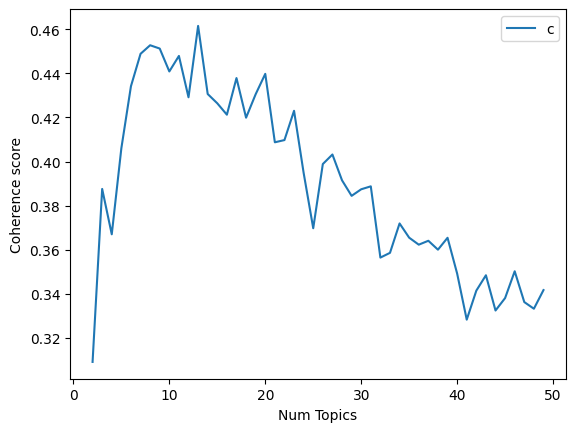

In [32]:
# Show graph
limit=50; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()# Print the coherence scores


In [33]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3092
Num Topics = 3  has Coherence Value of 0.3876
Num Topics = 4  has Coherence Value of 0.367
Num Topics = 5  has Coherence Value of 0.406
Num Topics = 6  has Coherence Value of 0.4341
Num Topics = 7  has Coherence Value of 0.4488
Num Topics = 8  has Coherence Value of 0.4527
Num Topics = 9  has Coherence Value of 0.4512
Num Topics = 10  has Coherence Value of 0.4408
Num Topics = 11  has Coherence Value of 0.4479
Num Topics = 12  has Coherence Value of 0.4291
Num Topics = 13  has Coherence Value of 0.4615
Num Topics = 14  has Coherence Value of 0.4306
Num Topics = 15  has Coherence Value of 0.4264
Num Topics = 16  has Coherence Value of 0.4212
Num Topics = 17  has Coherence Value of 0.4378
Num Topics = 18  has Coherence Value of 0.4199
Num Topics = 19  has Coherence Value of 0.4305
Num Topics = 20  has Coherence Value of 0.4397
Num Topics = 21  has Coherence Value of 0.4087
Num Topics = 22  has Coherence Value of 0.4097
Num Topics = 23  has Co

In [ ]:
# Select the model and print the topics
optimal_model = model_list[7]
model_topics = optimal_model.show_topics(formatted=False)
optimal_model.print_topics(num_words=10)

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, doc_term_matrix, dictionary)
vis